# Identifying Animal Crossing or Doom in Reddit Posts

In [359]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Reading in training and testing sets as well as TensorFlow Image Predictions 

In [360]:
train = pd.read_csv('train.csv')
train_pred = pd.read_csv('TrainPred.csv')

In [361]:
test = pd.read_csv('test.csv')
test_pred = pd.read_csv('TestPred.csv')

In [362]:
#Looking at predictions column names
train_pred.head()

,File,AnimalCrossingWeights,DoomWeights
0,003kprvwysr41.jpg,-0.281085,0.430738
1,0177myxmpiq41.jpg,-0.281240,0.430935
2,01vmlf4buap41.jpg,-0.105872,0.210422
3,04z5q0nunyt41.png,-0.281240,0.430935
4,05tmnohw0qn41.png,0.051152,0.013550


## Natural Language Processing on the posting titles

In [363]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2, SelectKBest

### Create Functions to determine top words associated with each type of image

In [364]:
# Get top n tfidf values in row and return them with their corresponding feature names.
def top_tfidf_feats(row, features, top_n=25):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [365]:
# Top tfidf features in specific document (matrix row)
def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [366]:
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [367]:
def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [368]:
!pip install nltk
import nltk
#nltk.download('vader_lexicon')
#nltk.download('stopwords')

You should consider upgrading via the 'C:\Users\Tonyj\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


### Create a list of stop words to ignore

In [369]:
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))

#Add aditional stop words that would potentially overfit the model
stop.extend('doom animal crossing doomguy bethesda id'.split())

### Create the vectorizer to analyse the text

In [370]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word',stop_words= set(stop))

### Create the vector that reads the text on the image

In [371]:
tfidf_vector = tfidf_vectorizer.fit_transform(train['title'])
tfidf_vector

<1277x2572 sparse matrix of type '<class 'numpy.float64'>'
	with 5839 stored elements in Compressed Sparse Row format>

### Convert the vector into a Data Frame with all the words as features

In [372]:
tfidf_df = pd.DataFrame(tfidf_vector.toarray(), columns=tfidf_vectorizer.get_feature_names())
tfidf_df

C:\Users\Tonyj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,000,03,10,100,10000,100k,101,11,1100,1176,...,yum,yup,zen,zieguy,zombie,zombies,zoo,zucker,ａｅｓｔｈｅｔｉｃ,ｃｒｏｓｓｉｎｇ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Fine the top 15 words associated with each image. We can make those words into features and take the vector values from the selected words as new data points for our model.

In [373]:
dfs = top_feats_by_class(tfidf_vector,train['subreddit'],tfidf_vectorizer.get_feature_names(),top_n=15)

C:\Users\Tonyj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Visualize the top 15 features associated with both Classifications

In [374]:
import matplotlib.pyplot as plt

# Plot the data frames returned by the function plot_tfidf_classfeats().
def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(30, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=25)
        ax.set_title("label = " + str(df.label), fontsize=30)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#005035')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature,fontsize=20)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

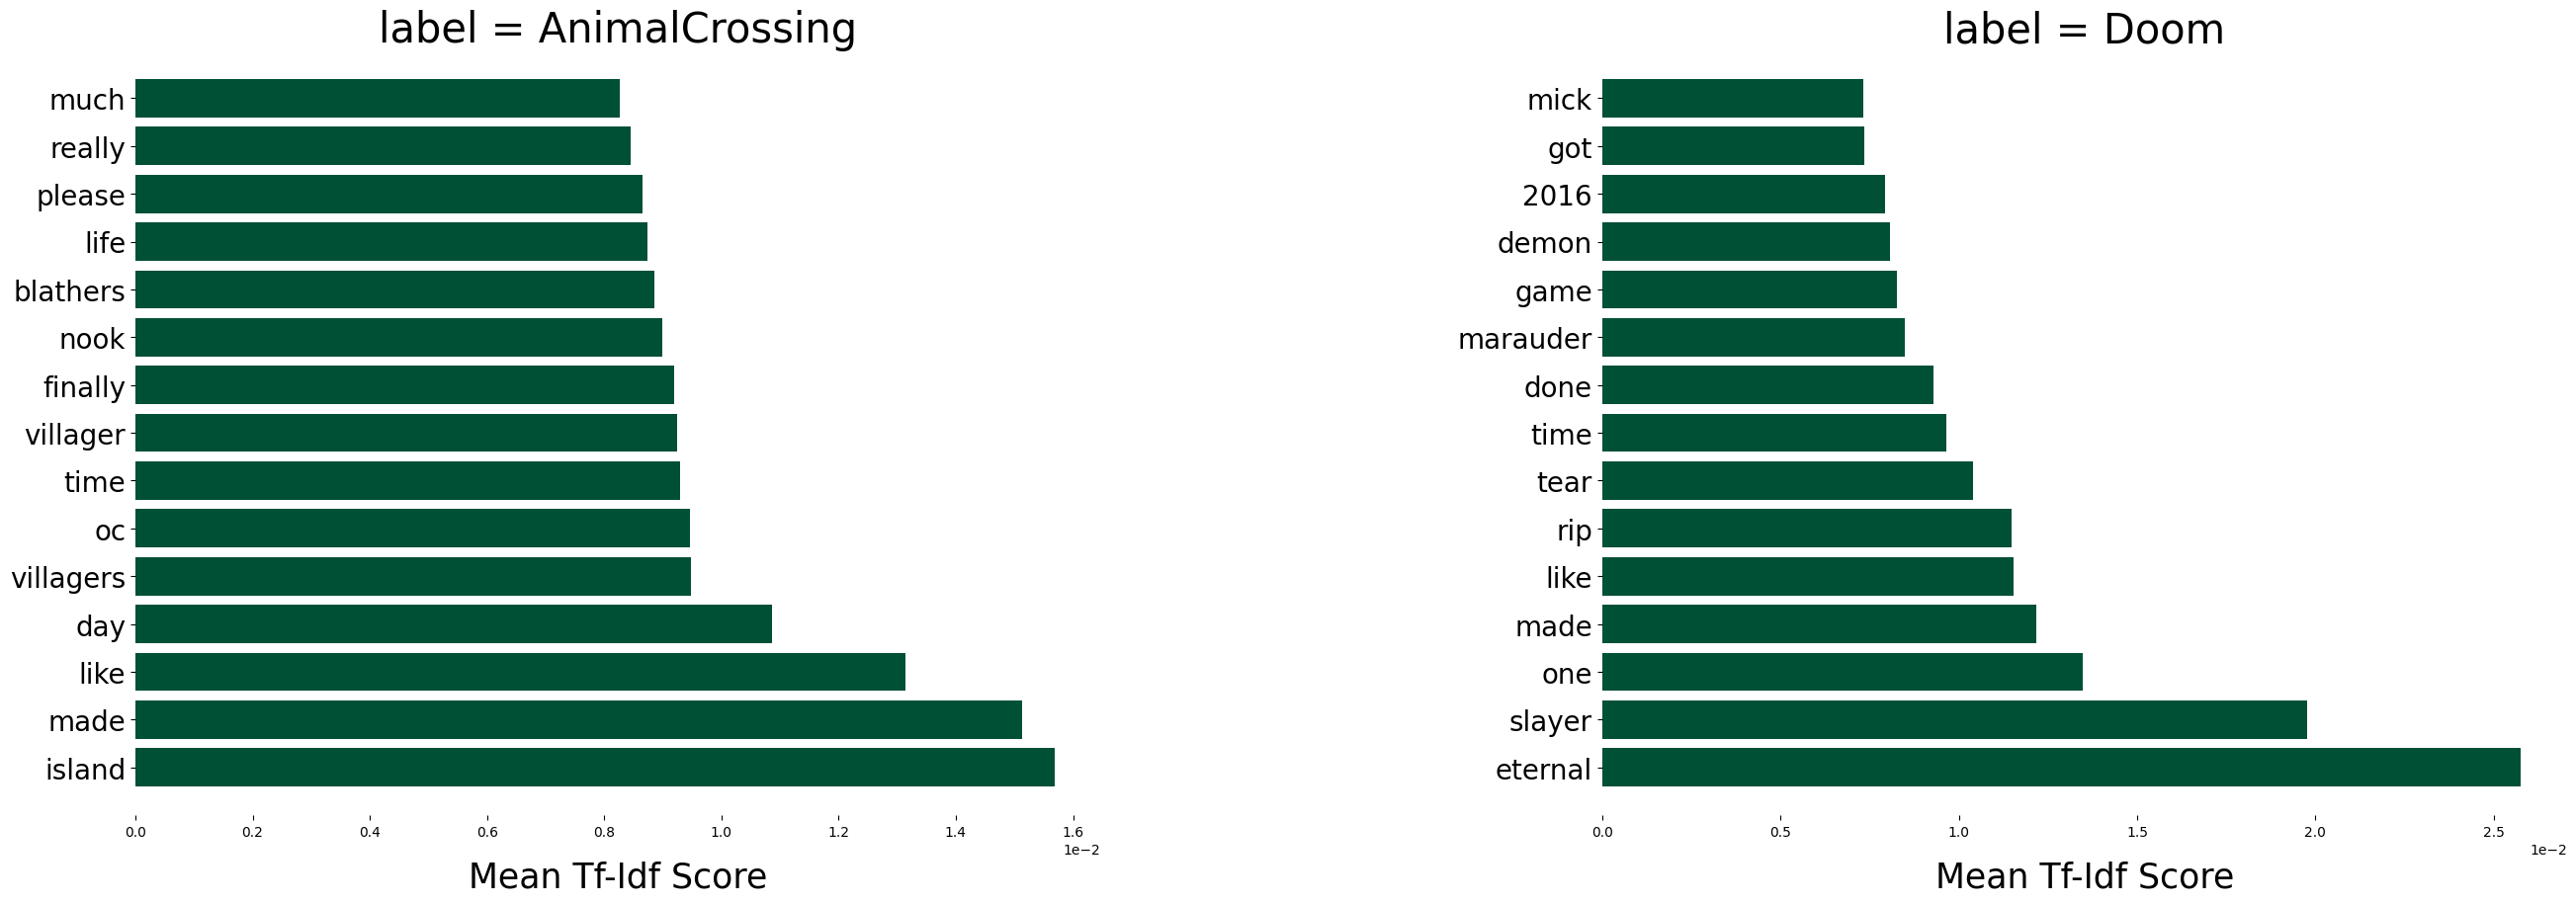

In [375]:
plot_tfidf_classfeats_h(dfs)

### Add the selected words as features in our training data for the model

In [376]:
train[['much','really','please','life','blathers','nook','finally','villager','time','oc','villagers','day','like','made','island','mick','got','2016','demon','game','marauder','done','tear','rip','one','slayer','eternal']] = tfidf_df[['much','really','please','life','blathers','nook','finally','villager','time','oc','villagers','day','like','made','island','mick','got','2016','demon','game','marauder','done','tear','rip','one','slayer','eternal']]

### Repeat the methodology for the testing set

In [377]:
tfidf_vector2 = tfidf_vectorizer.fit_transform(test['title'])
tfidf_vector2

<320x994 sparse matrix of type '<class 'numpy.float64'>'
	with 1525 stored elements in Compressed Sparse Row format>

In [378]:
tfidf_df2 = pd.DataFrame(tfidf_vector2.toarray(), columns=tfidf_vectorizer.get_feature_names())
tfidf_df2

C:\Users\Tonyj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,000,10,100,10000,1665,19,20,200,2014,2016,...,yeah,years,yeet,yes,yesterday,yet,zen,zombies,zoo,ウーフ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
316,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
317,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
318,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [379]:
test[['much','really','please','life','blathers','nook','finally','villager','time','oc','villagers','day','like','made','island','mick','got','2016','demon','game','marauder','done','tear','rip','one','slayer','eternal']] = tfidf_df2[['much','really','please','life','blathers','nook','finally','villager','time','oc','villagers','day','like','made','island','mick','got','2016','demon','game','marauder','done','tear','rip','one','slayer','eternal']]

## Merge the predictions from Tensor Flow into the datasets

In [380]:
train = train.merge(train_pred,how='inner',left_on='filename',right_on='File')

In [381]:
test = test.merge(test_pred,how='inner',left_on='filename',right_on='File')

In [382]:
train.head()

,Unnamed: 0,index,subreddit,id,title,ups,downs,upvote_ratio,total_awards_received,num_comments,...,marauder,done,tear,rip,one,slayer,eternal,File,AnimalCrossingWeights,DoomWeights
0,1148,699,AnimalCrossing,fwoh0n,Oh no he has discovered my shrine!,12239,0,0.99,1,142,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,q5v956sajfr41.jpg,-0.275963,0.424229
1,1337,22,Doom,gh5puq,Not sure if this has been made before but...,12507,0,0.97,1,103,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,g0ffa5l44zx41.jpg,0.300478,-0.298994
2,1443,218,AnimalCrossing,6564aw,"Hope you guys haven't seen this before, I thou...",28240,0,0.91,0,679,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,qavfy00f8cry.jpg,-0.244870,0.385208
3,868,127,AnimalCrossing,g5681m,I recently found out that everybody hates Rodn...,37861,0,0.94,6,726,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,GP2Izrk.jpg,0.385279,-0.405017
4,1355,768,Doom,fnh8er,Rip and Tear,2533,0,1.00,0,88,...,0.0,0.0,0.71131,0.702879,0.0,0.0,0.0,c79oubyo5eo41.jpg,0.361384,-0.377136


Standardizing the data for the models

In [383]:
#Create function to standardize columns in the data set
def ZStandardize(array):
    if len(array.unique()) > 2:
        mean = array.mean()
        std = array.std()
        new_array = (array - mean)/std
        return(new_array)
    else:
        return(array)

In [384]:
train['ups']= ZStandardize(train['ups'])
test['ups']=ZStandardize(test['ups'])

train['downs']=ZStandardize(train['downs'])
test['downs']=ZStandardize(train['downs'])

train['total_awards_received']=ZStandardize(train['total_awards_received'])
test['total_awards_received']=ZStandardize(train['total_awards_received'])

train['num_comments']=ZStandardize(train['num_comments'])
test['num_comments']=ZStandardize(train['num_comments'])

In [385]:
train.describe()

,Unnamed: 0,index,ups,downs,upvote_ratio,total_awards_received,num_comments,created_utc,much,really,...,game,marauder,done,tear,rip,one,slayer,eternal,AnimalCrossingWeights,DoomWeights
count,1276.000000,1276.000000,1.276000e+03,1276.0,1276.000000,1.276000e+03,1.276000e+03,1.276000e+03,1276.000000,1276.000000,...,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000
mean,796.785266,396.506270,-5.568517e-17,0.0,0.979624,-1.113703e-17,-5.568517e-18,1.583636e+09,0.005526,0.005700,...,0.007600,0.004461,0.006470,0.005613,0.006039,0.011083,0.010391,0.013551,-0.053802,0.145277
std,461.939513,233.159319,1.000000e+00,0.0,0.016934,1.000000e+00,1.000000e+00,9.696788e+06,0.052364,0.047364,...,0.051907,0.044949,0.065253,0.055627,0.057035,0.063839,0.061396,0.071827,0.292062,0.366646
min,0.000000,1.000000,-8.630959e-01,0.0,0.840000,-4.629612e-01,-8.990610e-01,1.492097e+09,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.281240,-0.408853
25%,394.750000,193.750000,-7.726166e-01,0.0,0.970000,-4.629612e-01,-5.778391e-01,1.584654e+09,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.281240,-0.335883
50%,789.500000,395.500000,-1.906486e-01,0.0,0.980000,-4.629612e-01,-2.872098e-01,1.586358e+09,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.280789,0.430327
75%,1203.500000,596.250000,2.751651e-01,0.0,0.990000,1.614981e-01,1.917549e-01,1.588439e+09,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.332731,0.430935
max,1596.000000,838.000000,5.230967e+00,0.0,1.000000,1.140176e+01,1.253490e+01,1.591278e+09,1.000000,0.588345,...,0.584930,0.598156,1.000000,0.711310,0.702879,0.654745,0.536901,1.000000,0.386905,0.430935


# Modelling

In [386]:
x_train = train[['downs','total_awards_received','num_comments','nook','finally','villager','time','oc','villagers','day','like','made','island','marauder','done','tear','rip','one','slayer','eternal','AnimalCrossingWeights', 'DoomWeights']]
y_train = train['subreddit']

In [387]:
x_test = test[['downs','total_awards_received','num_comments','nook','finally','villager','time','oc','villagers','day','like','made','island','marauder','done','tear','rip','one','slayer','eternal','AnimalCrossingWeights', 'DoomWeights']]
y_test = test['subreddit']

### Random Forest

In [388]:
rf01 = RandomForestClassifier(n_estimators = 100,criterion="gini",random_state=7).fit(x_train,y_train)
prediction_rf01 = rf01.predict(x_test)

# Summary of the predictions made by the classifier
print(classification_report(y_test, prediction_rf01))
print('Confusion Matrix')
print(confusion_matrix(y_test, prediction_rf01))
# Accuracy score
print('accuracy is',accuracy_score(prediction_rf01,y_test))

test_predictions_proba = rf01.predict_proba(x_test)
ll = log_loss(y_test, test_predictions_proba)
print("Log Loss: {:.4}".format(ll))
print("="*30)

                precision    recall  f1-score   support

AnimalCrossing       0.61      0.58      0.59       151
          Doom       0.64      0.67      0.65       167

      accuracy                           0.63       318
     macro avg       0.62      0.62      0.62       318
  weighted avg       0.63      0.63      0.62       318

Confusion Matrix
[[ 87  64]
 [ 55 112]]
accuracy is 0.6257861635220126
Log Loss: 0.8352


************* **Naive Bayes Model that is not  working with the negative weights** ********************************

nb = MultinomialNB().fit(x_train,y_train)
nb_predict = nb.predict(x_test)


print(classification_report(y_test, nb_predict))
print('Confusion Matrix')
print(confusion_matrix(y_test, nb_predict))

print('accuracy is',accuracy_score(nb_predict,y_test))

test_predictions_proba = nb.predict_proba(x_test)
ll = log_loss(y_test, test_predictions_proba)
print("Log Loss: {:.4}".format(ll))
print("="*30)

************* **Naive Bayes Model that is not  working with the negative weights** ********************************

### KNN

In [389]:
kn = KNeighborsClassifier().fit(x_train,y_train)
kn_predict = kn.predict(x_test)

# Summary of the predictions made by the classifier
print(classification_report(y_test, kn_predict))
print('Confusion Matrix')
print(confusion_matrix(y_test, kn_predict))
# Accuracy score
print('accuracy is',accuracy_score(kn_predict,y_test))

test_predictions_proba = kn.predict_proba(x_test)
ll = log_loss(y_test, test_predictions_proba)
print("Log Loss: {:.4}".format(ll))
print("="*30)

                precision    recall  f1-score   support

AnimalCrossing       0.60      0.58      0.59       151
          Doom       0.63      0.65      0.64       167

      accuracy                           0.62       318
     macro avg       0.62      0.61      0.61       318
  weighted avg       0.62      0.62      0.62       318

Confusion Matrix
[[ 88  63]
 [ 59 108]]
accuracy is 0.6163522012578616
Log Loss: 5.103


### SVM

In [390]:
sv = svm.SVC().fit(x_train,y_train)
sv_predict = sv.predict(x_test)

# Summary of the predictions made by the classifier
print(classification_report(y_test, sv_predict))
print('Confusion Matrix')
print(confusion_matrix(y_test, sv_predict))
# Accuracy score
print('accuracy is',accuracy_score(sv_predict,y_test))

#test_predictions_proba = sv.predict_proba(x_test)
ll = log_loss(y_test, test_predictions_proba)
print("Log Loss: {:.4}".format(ll))
print("="*30)

                precision    recall  f1-score   support

AnimalCrossing       0.69      0.66      0.67       151
          Doom       0.70      0.73      0.72       167

      accuracy                           0.69       318
     macro avg       0.69      0.69      0.69       318
  weighted avg       0.69      0.69      0.69       318

Confusion Matrix
[[ 99  52]
 [ 45 122]]
accuracy is 0.6949685534591195
Log Loss: 5.103


### Logistic Regression

In [391]:
logi = LogisticRegression().fit(x_train,y_train)
logi_predict = logi.predict(x_test)

# Summary of the predictions made by the classifier
print(classification_report(y_test, logi_predict))
print('Confusion Matrix')
print(confusion_matrix(y_test, logi_predict))
# Accuracy score
print('accuracy is',accuracy_score(logi_predict,y_test))

#test_predictions_proba = sv.predict_proba(x_test)
ll = log_loss(y_test, test_predictions_proba)
print("Log Loss: {:.4}".format(ll))
print("="*30)

                precision    recall  f1-score   support

AnimalCrossing       0.74      0.64      0.69       151
          Doom       0.71      0.80      0.75       167

      accuracy                           0.72       318
     macro avg       0.73      0.72      0.72       318
  weighted avg       0.73      0.72      0.72       318

Confusion Matrix
[[ 97  54]
 [ 34 133]]
accuracy is 0.7232704402515723
Log Loss: 5.103


## **Hyper-Parameter tuning**

In [392]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

### Tuning Number of Estimators

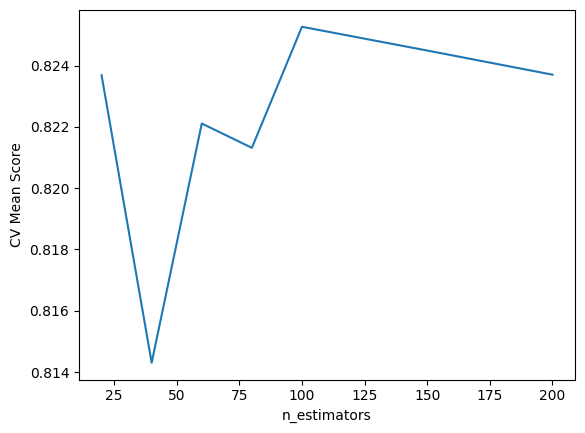

In [393]:
estimators = [20,40,60,80,100,150,200]

scores = []
for estimator in estimators:
    #Create random forest model
    rf = RandomForestClassifier(n_estimators = estimator,random_state=7).fit(x_train,y_train)
    #Evaluate with k-fold cv
    rf_cv_scores = cross_val_score(rf, x_train , y_train, cv=KFold(n_splits=10, random_state=1, shuffle=True))
    scores.append(rf_cv_scores.mean())

plt.plot(estimators, scores)
plt.ylabel('CV Mean Score')
plt.xlabel('n_estimators')
plt.show()

### Tuning for Split Criteria

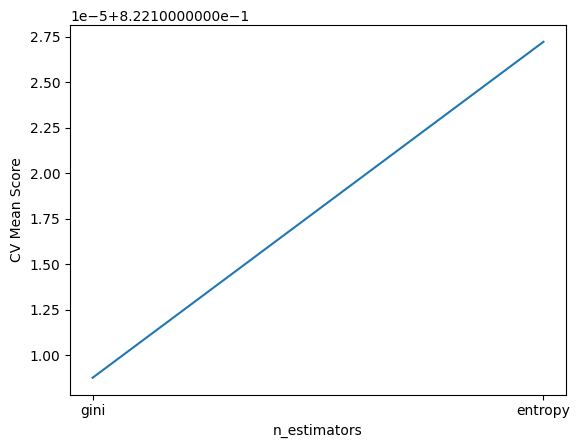

In [394]:
criteria = ['gini','entropy']

scores = []
for i in criteria:
    #Create random forest model
    rf = RandomForestClassifier(n_estimators = 60, criterion=i,random_state=7).fit(x_train,y_train)
    #Evaluate with k-fold cv
    rf_cv_scores = cross_val_score(rf, x_train , y_train, cv=KFold(n_splits=10, random_state=1, shuffle=True))
    scores.append(rf_cv_scores.mean())

plt.plot(criteria, scores)
plt.ylabel('CV Mean Score')
plt.xlabel('n_estimators')
plt.show()

# Final Model

In [395]:
rf01 = RandomForestClassifier(n_estimators = 60,criterion="gini",random_state=7).fit(x_train,y_train)
prediction_rf01 = rf01.predict(x_test)

# Summary of the predictions made by the classifier
print(classification_report(y_test, prediction_rf01))
print('Confusion Matrix')
print(confusion_matrix(y_test, prediction_rf01))
# Accuracy score
print('accuracy is',accuracy_score(prediction_rf01,y_test))

test_predictions_proba = rf01.predict_proba(x_test)
ll = log_loss(y_test, test_predictions_proba)
print("Log Loss: {:.4}".format(ll))
print("="*30)

                precision    recall  f1-score   support

AnimalCrossing       0.62      0.57      0.59       151
          Doom       0.64      0.68      0.66       167

      accuracy                           0.63       318
     macro avg       0.63      0.63      0.63       318
  weighted avg       0.63      0.63      0.63       318

Confusion Matrix
[[ 86  65]
 [ 53 114]]
accuracy is 0.6289308176100629
Log Loss: 0.8404


### Feature Importances

C:\Users\Tonyj\AppData\Local\Temp\ipykernel_12184\386407015.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')


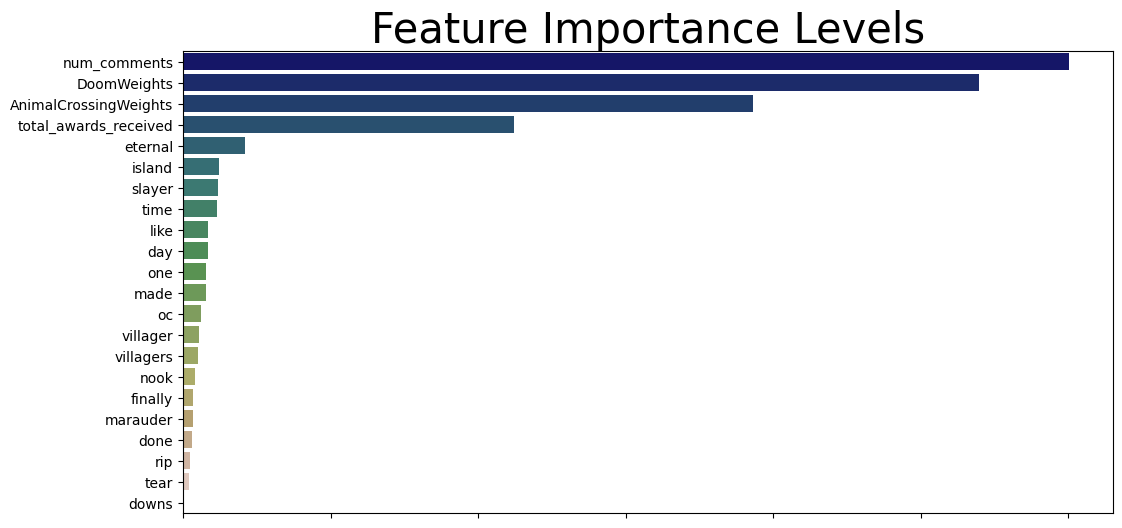

In [398]:
fi = rf01.feature_importances_ #feature importance array
fi = pd.Series(data = fi, index = x_train.columns) #convert to Pandas series for plotting
fi.sort_values(ascending=False, inplace=True) #sort descending

#create bar plot
plt.figure(figsize=(12, 6))
plt.title('Feature Importance Levels',fontsize=30)
chart = sns.barplot(x=fi, y=fi.index, palette=sns.color_palette("gist_earth", n_colors=len(fi)))
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()